In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import keras_tuner as tuner

from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import os

imgs_dir = os.listdir("./")
imgs_dir = imgs_dir[2:]
imgs_dir

['.vscode',
 'app.py',
 'bird_image_classification.h5',
 'bird_image_classification.ipynb',
 'images to predict',
 'requirements.txt',
 'test',
 'train',
 'valid']

In [3]:
classes = os.listdir("train")
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

In [4]:
test_imgs_paths = []
train_imgs_paths = []
valid_imgs_paths = []
for _dir in imgs_dir[1:]:
    c=0
    for _sub_dir in classes:
        if _dir == 'test':
           for img in os.listdir(os.path.join(_dir+'/'+_sub_dir)):
               test_imgs_paths.append([os.path.join(_dir+'/'+_sub_dir+'/'+img),_sub_dir])
        if _dir == 'train':
           for img in os.listdir(os.path.join(_dir+'/'+_sub_dir)):
               c+=1
               train_imgs_paths.append([os.path.join(_dir+'/'+_sub_dir+'/'+img),_sub_dir])
        if _dir == 'valid':
           for img in os.listdir(os.path.join(_dir+'/'+_sub_dir)):
               valid_imgs_paths.append([os.path.join(_dir+'/'+_sub_dir+'/'+img),_sub_dir])

In [5]:
test_imgs_arr = []
for img in test_imgs_paths:
    _img = Image.open(img[0])
    test_imgs_arr.append([img_to_array(_img),img[1]])
    
train_imgs_arr = []
for img in train_imgs_paths:
    _img = Image.open(img[0])
    train_imgs_arr.append([img_to_array(_img),img[1]])

valid_imgs_arr = []
for img in valid_imgs_paths:
    _img = Image.open(img[0])
    valid_imgs_arr.append([img_to_array(_img),img[1]])

In [6]:
train_images = np.array([img[0] for img in train_imgs_arr])
X_train = train_images/255
train_labels = np.array([img[1] for img in train_imgs_arr])

test_images = np.array([img[0] for img in test_imgs_arr])
X_test = test_images/255
test_labels = np.array([img[1] for img in test_imgs_arr])

train_images, train_labels = sk.utils.shuffle(train_images,train_labels)

valid_images = np.array([img[0] for img in valid_imgs_arr])
X_val = valid_images/255
valid_labels = np.array([img[1] for img in valid_imgs_arr])
train_labels

array(['ALTAMIRA YELLOWTHROAT', 'AMERICAN KESTREL', 'AMERICAN BITTERN',
       ..., 'AMERICAN FLAMINGO', 'AFRICAN OYSTER CATCHER',
       'AFRICAN FIREFINCH'], dtype='<U26')

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
valid_labels_encoded = encoder.transform(valid_labels)

y_train = tf.keras.utils.to_categorical(train_labels_encoded, 20)
y_val = tf.keras.utils.to_categorical(valid_labels_encoded, 20)

### The below two cells are for Hyperparameter tunning using keras-tuner.

In [10]:
def build_model(hp):
    model = Sequential()
    
    model.add(Input((224,224,3),dtype='float32'))
    
    for i in range(hp.Int('conv_blocks', 1, 3, default=2)):
        for _ in range(hp.Int('conv_layers_per_block', 1, 3, default=2)):
            model.add(Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32, default=64),
                kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5], default=3),
                activation='relu',
                padding='same'
            ))
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    
    model.add(Flatten())
    
    for i in range(hp.Int('dense_layers', 1, 3, default=2)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64, default=128),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Float(f'dense_dropout_{i}', min_value=0.0, max_value=0.5, step=0.05, default=0.25)))
    
    model.add(Dense(20, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [12]:
_tuner = tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    executions_per_trial=2,
)

In [ ]:
_tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

In [ ]:
_tuner.get_best_hyperparameters()[0].values

In [ ]:
model = _tuner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

## Visualizing few Images from train data.

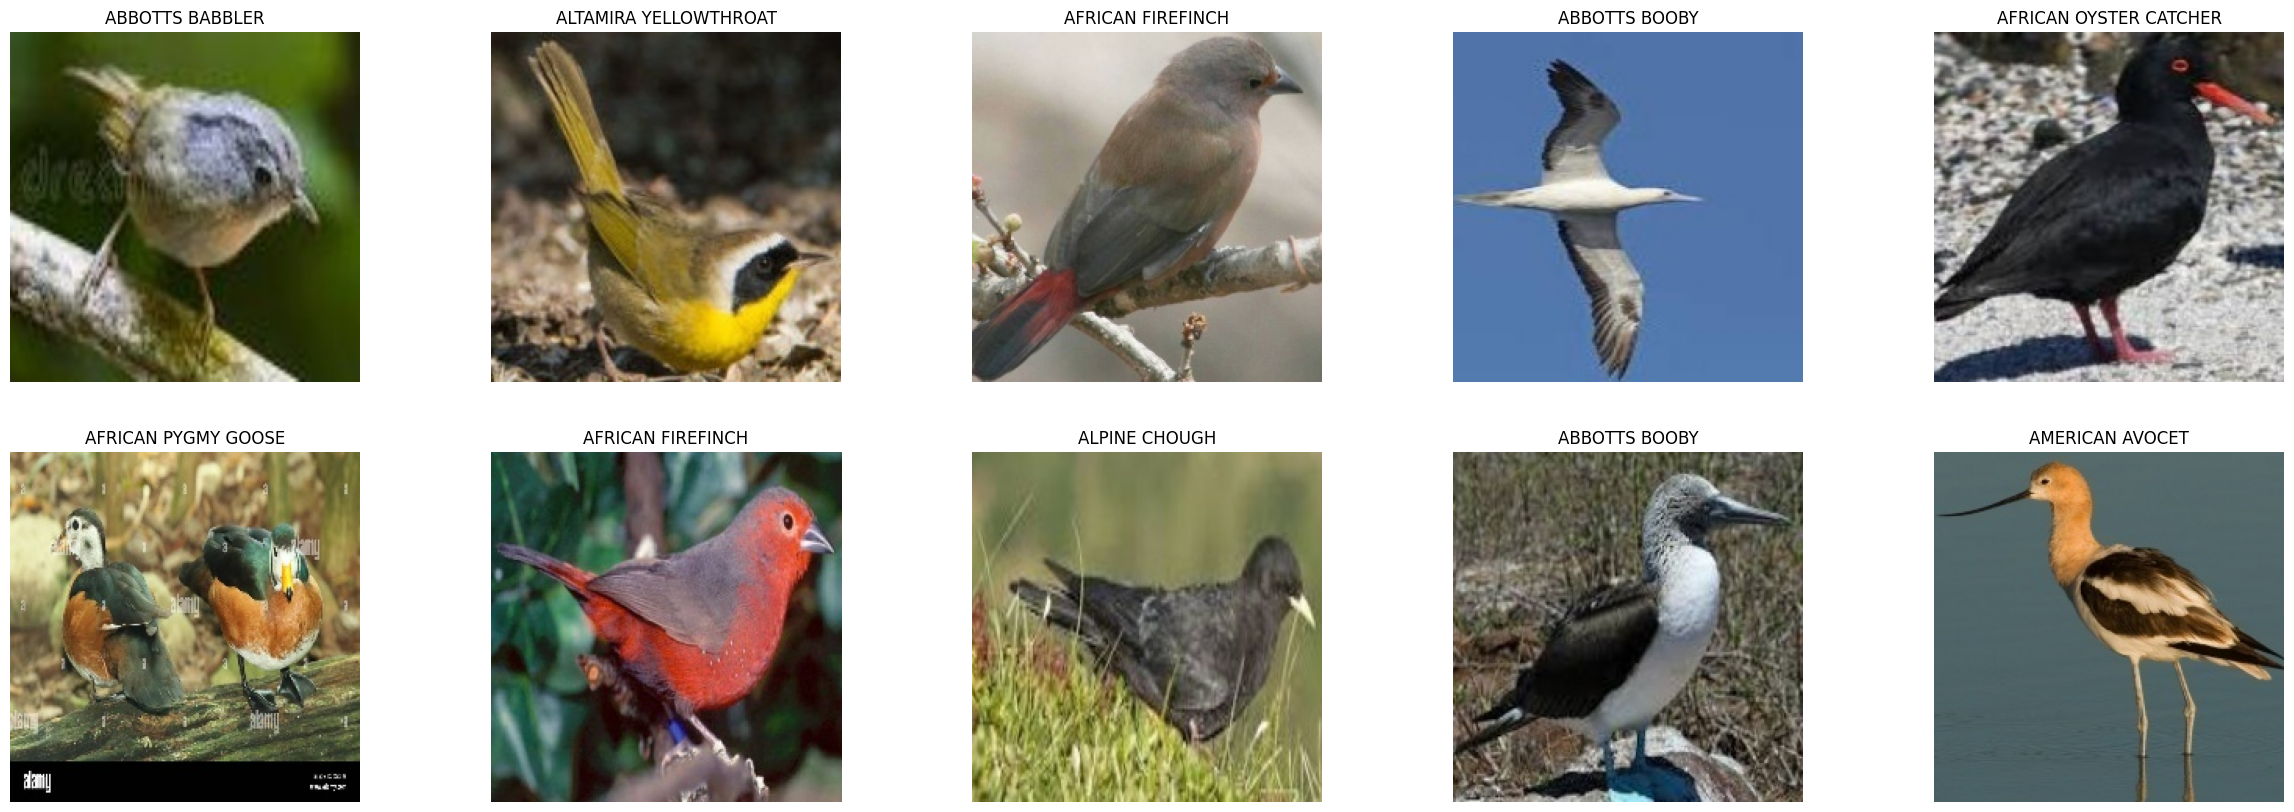

In [8]:
# visualize some random images from train data.
import random
random_images = random.sample(train_imgs_arr,10)

fig, axes = plt.subplots(2, 5, figsize=(30,10))
for i,img in enumerate(random_images):
    row = i // 5
    col = i % 5
    axes[row,col].imshow(img[0]/255)
    axes[row,col].axis('off')
    axes[row,col].set_title(img[1])
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

tf.random.set_seed(42)

train_dir = './train'
valid_dir =  './valid'

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              seed = 42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              seed = 42)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


## Using different AlexNet for Image Classification.

In [18]:
model= tf.keras.Sequential([
    # Layer-1
    Conv2D(64, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    Dropout(0.2),
    
    # Layer-2
    Conv2D(192, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    Dropout(0.2),

    # Layer-3
    Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    Flatten(),
    # Layer-4
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
             metrics = ['accuracy'])

In [19]:
history = model.fit(train_data_augmented,shuffle=True,epochs = 75,validation_data=valid_data)

Epoch 1/75
101/101 [==============================] - 77s 753ms/step - loss: 2.9548 - accuracy: 0.0614 - val_loss: 2.7697 - val_accuracy: 0.1500
Epoch 2/75
101/101 [==============================] - 73s 718ms/step - loss: 2.7784 - accuracy: 0.1085 - val_loss: 2.6421 - val_accuracy: 0.2100
Epoch 3/75
101/101 [==============================] - 67s 664ms/step - loss: 2.5320 - accuracy: 0.1686 - val_loss: 2.3196 - val_accuracy: 0.2700
Epoch 4/75
101/101 [==============================] - 67s 662ms/step - loss: 2.3106 - accuracy: 0.2491 - val_loss: 2.1833 - val_accuracy: 0.2900
Epoch 5/75
101/101 [==============================] - 68s 669ms/step - loss: 2.1464 - accuracy: 0.2993 - val_loss: 1.9346 - val_accuracy: 0.4200
Epoch 6/75
101/101 [==============================] - 84s 833ms/step - loss: 1.9961 - accuracy: 0.3597 - val_loss: 1.8783 - val_accuracy: 0.4500
Epoch 7/75
101/101 [==============================] - 74s 742ms/step - loss: 1.8882 - accuracy: 0.3897 - val_loss: 1.6715 - val_ac

['bird_image_classification.joblib']

In [21]:
from tensorflow.keras.models import save_model

save_model(model, 'bird_image_classification.keras')